In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(
    style="whitegrid",
    font_scale=2
);

# 0. Data loading <a class="anchor" id="section_1"></a>

In [2]:
DATA_FOLDER = Path('./data')
FRAME_LENGTH = 30
classes = [f.name for f in DATA_FOLDER.iterdir()]
classes

['running', 'stairs', 'walking', 'idle']

In [17]:
x_acc_cols = [f'acc_x_{i}' for i in range(FRAME_LENGTH)]
y_acc_cols = [f'acc_y_{i}' for i in range(FRAME_LENGTH)]
z_acc_cols = [f'acc_z_{i}' for i in range(FRAME_LENGTH)]

frames = []
labels = []

for class_name in classes:
    class_folder = DATA_FOLDER / class_name
    for file in class_folder.iterdir():
        df = pd.read_csv(file)
        flat_frame = np.hstack([df['accelerometer_X'], df['accelerometer_Y'], df['accelerometer_Z']]).astype(float)
        frames.append(flat_frame)
        labels.append(class_name)
        
raw_data = pd.DataFrame(frames, columns = x_acc_cols+y_acc_cols+z_acc_cols)
raw_data = pd.concat([raw_data, pd.Series(labels, name='label')], axis=1)
raw_data.head(3)

,acc_x_0,acc_x_1,acc_x_2,acc_x_3,acc_x_4,acc_x_5,acc_x_6,acc_x_7,acc_x_8,acc_x_9,...,acc_z_21,acc_z_22,acc_z_23,acc_z_24,acc_z_25,acc_z_26,acc_z_27,acc_z_28,acc_z_29,label
0,2.667141,4.017470,22.357056,17.922995,-2.164358,9.749189,3.303998,-3.275268,5.252879,21.490355,...,13.493721,-2.001553,16.668432,9.208099,-7.187393,12.430696,-8.939949,1.470040,10.807426,running
1,10.745177,3.744532,0.766145,23.956383,-0.454898,-3.481169,3.572149,7.527370,-10.793061,9.481039,...,11.468226,-0.952892,-0.943315,-0.416591,0.483629,0.363919,1.699883,3.390190,-1.407790,running
2,22.031445,3.600880,-0.354342,8.245631,18.641254,4.381389,26.499025,4.003105,3.284845,2.231396,...,0.565032,-4.079719,-3.677494,4.596867,-0.550666,-6.019023,-1.139640,-2.164358,-3.016694,running


In [4]:
raw_data.shape

(6462, 91)

In [156]:
raw_data['label'].value_counts()

running    3408
walking    1850
idle       1039
stairs      165
Name: label, dtype: int64

In [157]:
165/6462

0.0255338904363974

# 2. Setup validation and baselines 

## 2.1 StratifiedKFold

In [5]:
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [6]:
X = raw_data['acc_x_0']
y = raw_data['label']

for i, (_, valid_ix) in enumerate(kfold.split(X, y)):
    y_valid = y.loc[valid_ix]
    value_counts = y_valid.value_counts()
    print(f'split#{i}, we have {value_counts.stairs} stairs, {value_counts.running} running samples')
#     print(    (y_valid == 'stairs').index)

split#0, we have 33 stairs, 682 running samples
split#1, we have 33 stairs, 682 running samples
split#2, we have 33 stairs, 682 running samples
split#3, we have 33 stairs, 681 running samples
split#4, we have 33 stairs, 681 running samples


# Clean feature extraction

In [75]:
def extract_features(x_part, y_part, z_part):
    magnitude_part = np.sqrt(x_part**2 + y_part**2 + z_part**2)
    ts_matrix = np.stack([x_part, y_part, z_part, magnitude_part], axis=1)
    ts_ax_names = ['x', 'y', 'z', 'm']
    assert len(ts_ax_names) == ts_matrix.shape[1]
    
    mean_features = pd.DataFrame(ts_matrix.mean(axis=2), columns=[f'mean_{ax}' for ax in ts_ax_names])
    
    minmax_m = ts_matrix.max(axis=2) - ts_matrix.min(axis=2)
    minmax_features = pd.DataFrame(minmax_m, columns=[f'minmax_{ax}' for ax in ts_ax_names])
    
    std_m = ts_matrix.std(axis=2)
    std_features = pd.DataFrame(std_m, columns=[f'std_{ax}' for ax in ts_ax_names])
    
    min_m = ts_matrix.min(axis=2)
    min_features = pd.DataFrame(min_m, columns=[f'min_{ax}' for ax in ts_ax_names])
    
    rms_m = np.sqrt(np.square(ts_matrix).mean(axis=2))
    rms_features = pd.DataFrame(rms_m, columns=[f'rms_{ax}' for ax in ts_ax_names])
    
    ix = np.arange(len(ts_matrix))
    iy = ix + len(ts_matrix)
    corr_xy = np.corrcoef(ts_matrix[:, 0, :], ts_matrix[:, 1, :])[ix,iy]
    corr_yz = np.corrcoef(ts_matrix[:, 1, :], ts_matrix[:, 2, :])[ix,iy]
    corr_xz = np.corrcoef(ts_matrix[:, 0, :], ts_matrix[:, 2, :])[ix,iy]
    corr_features = pd.DataFrame({'corr_xy': corr_xy, 'corr_yz': corr_yz, 'corr_xz': corr_xz})
    
    features = pd.concat([mean_features, minmax_features, min_features, rms_features, corr_features], axis=1)
    return features

In [76]:
feature_df = extract_features(
    raw_data[x_acc_cols].values,
    raw_data[y_acc_cols].values,
    raw_data[z_acc_cols].values)

In [78]:
feature_df.shape

(6462, 19)

LabelEncoder()

In [84]:
feature_df['label'] = target_le.transform(raw_data['label'])

In [85]:
feature_df.shape

(6462, 20)

# Modeling

In [86]:
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import f1_score, confusion_matrix, multilabel_confusion_matrix, accuracy_score

In [339]:
numerical_metrics = ['accuracy', 'f1_macro', 'f1_min']

def evaluate_performance(y_true, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_min': f1_score(y_true, y_pred, average=None).min(),
        'CM': confusion_matrix(y_true, y_pred, normalize='true'),
        'CM_not_normalized': confusion_matrix(y_true, y_pred),
    }
    
    return metrics

In [340]:
def plot_confusion_matrix(df):
    # C_ij - i is true, predicted in j
    cm = df['CM'].values.mean()
    cm_nn = df['CM_not_normalized'].values.mean()
    cm_print = np.empty_like(cm_nn).astype(str)
    for i in range(4):
        for j in range(4):
            cm_print[i,j] = ("%.2f" % (cm[i,j]*100))+'%\n'+str(cm_nn[i,j])
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.3)
    labels_ordered = target_encoder.inverse_transform(range(4))
    sns.heatmap(cm,
                annot=cm_print,
                fmt='',
                cmap='Blues',
                cbar=False,
                xticklabels=labels_ordered,
                yticklabels=labels_ordered,
               )
    plt.xlabel('predicted')
    plt.ylabel('actual');

In [341]:
def print_cv_metrics(cv_metrics):
    df = pd.DataFrame(cv_metrics)
    print_df = pd.concat([df.mean()[numerical_metrics], df.std()[numerical_metrics]], axis=1)
    print_df.columns = ['mean', 'std']
    print(print_df.T)
    plot_confusion_matrix(df)

## Baseline - ['mean_x', 'mean_y', 'mean_z']

[[208   0   0   0]
 [  4 678   0   0]
 [  0   0  11  22]
 [  0   0   3 367]]
[[208   0   0   0]
 [  2 680   0   0]
 [  0   0   8  25]
 [  0   0   1 369]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  11  22]
 [  0   0   1 369]]
[[208   0   0   0]
 [  3 678   0   0]
 [  0   0  10  23]
 [  0   0   9 361]]
[[208   0   0   0]
 [  1 680   0   0]
 [  0   0  13  20]
 [  0   0   7 363]]
        accuracy   f1_macro     f1_min
mean    0.977871    0.85032   0.442622
std   0.00331122  0.0151261  0.0553524


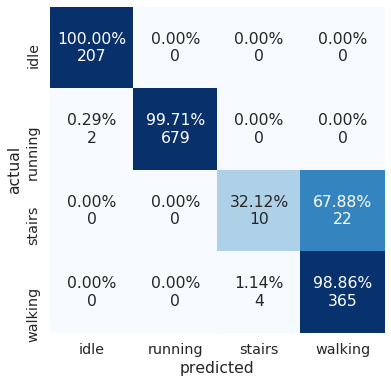

In [342]:
X = feature_df[['mean_x', 'mean_y', 'mean_z']]
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    cls = linear_model.LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics)

[[208   0   0   0]
 [  3 679   0   0]
 [  0   0  13  20]
 [  0   0   5 365]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  11  22]
 [  0   0   2 368]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  12  21]
 [  0   0   6 364]]
[[208   0   0   0]
 [  2 679   0   0]
 [  0   0  14  19]
 [  0   0  12 358]]
[[208   0   0   0]
 [  1 680   0   0]
 [  0   0  14  19]
 [  0   0   7 363]]
        accuracy    f1_macro     f1_min
mean    0.978489    0.862823    0.49035
std   0.00253573  0.00561759  0.0221213


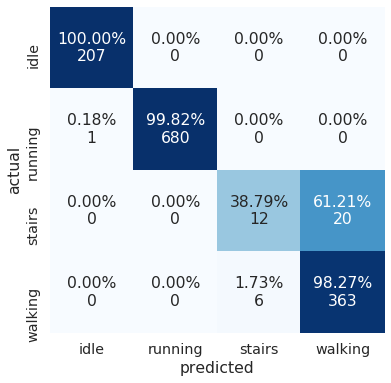

In [343]:
X = feature_df[['mean_x', 'mean_y', 'mean_z']]
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = linear_model.LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics)

## All features

In [306]:
all_features = [c for c in feature_df.columns if c != 'label']
all_features

['mean_x',
 'mean_y',
 'mean_z',
 'mean_m',
 'minmax_x',
 'minmax_y',
 'minmax_z',
 'minmax_m',
 'min_x',
 'min_y',
 'min_z',
 'min_m',
 'rms_x',
 'rms_y',
 'rms_z',
 'rms_m',
 'corr_xy',
 'corr_yz',
 'corr_xz']

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  23  10]
 [  0   0   2 368]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  29   4]
 [  0   0   9 361]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  26   7]
 [  0   0   3 367]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  23  10]
 [  0   0   4 366]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  29   4]
 [  0   0   2 368]]
        accuracy   f1_macro     f1_min
mean    0.991489    0.95238   0.824326
std   0.00244579  0.0142865  0.0530872


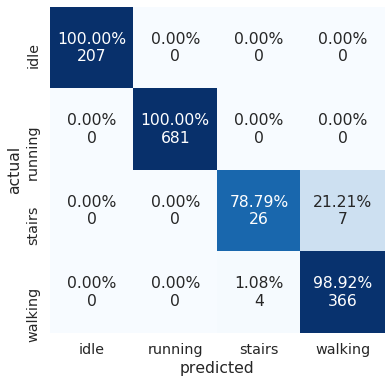

In [311]:
X = feature_df[all_features]
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_valid = scaler.transform(X_valid)
    
    cls = linear_model.LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics)

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  23  10]
 [  0   0   3 367]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  29   4]
 [  0   0   7 363]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  23  10]
 [  0   0   3 367]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  21  12]
 [  0   0   3 367]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  30   3]
 [  0   0   3 367]]
        accuracy   f1_macro     f1_min
mean    0.991025   0.948398   0.809167
std   0.00265825  0.0178619  0.0669769


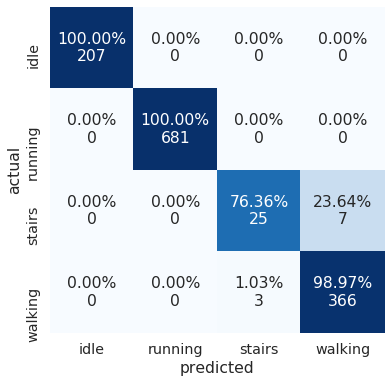

In [309]:
X = feature_df[all_features]
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    cls = linear_model.LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics)

## Poly 2

In [312]:
from sklearn.preprocessing import PolynomialFeatures

transform = PolynomialFeatures(2, include_bias=False)

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  28   5]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  33   0]
 [  0   0   3 367]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  31   2]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  29   4]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  32   1]
 [  0   0   0 370]]
        accuracy    f1_macro     f1_min
mean    0.997369    0.985539   0.946739
std   0.00140484  0.00810871  0.0300038


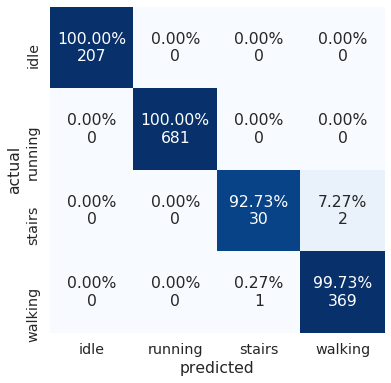

In [313]:
X = transform.fit_transform(feature_df[all_features])
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X[train_ix], X[valid_ix]
    y_train, y_valid = y[train_ix], y[valid_ix]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    cls = linear_model.LogisticRegression(max_iter=2_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  31   2]
 [  0   0   2 368]]


/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  33   0]
 [  0   0   1 369]]


/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  33   0]
 [  0   0   1 369]]


/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  31   2]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  32   1]
 [  0   0   0 370]]
        accuracy    f1_macro     f1_min
mean    0.998453    0.991725   0.969601
std   0.00109385  0.00587556  0.0215927


/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


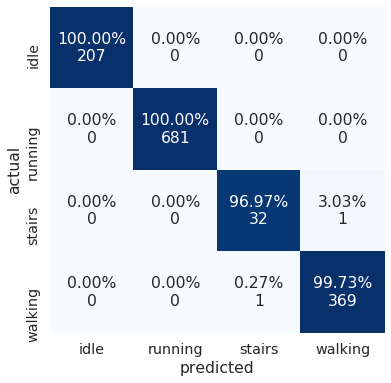

In [315]:
X = transform.fit_transform(feature_df[all_features])
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X[train_ix], X[valid_ix]
    y_train, y_valid = y[train_ix], y[valid_ix]
    
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_valid = scaler.transform(X_valid)
    cls = linear_model.LogisticRegression(max_iter=5_000)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics)

0.9032258064516129
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  28   5]
 [  0   0   1 369]]
0.9565217391304348
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  33   0]
 [  0   0   3 367]]
0.9538461538461539
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  31   2]
 [  0   0   1 369]]
0.9354838709677419
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  29   4]
 [  0   0   0 370]]
0.9846153846153847
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  32   1]
 [  0   0   0 370]]
        accuracy    f1_macro     f1_min
mean    0.997369    0.985539   0.946739
std   0.00140484  0.00810871  0.0300038


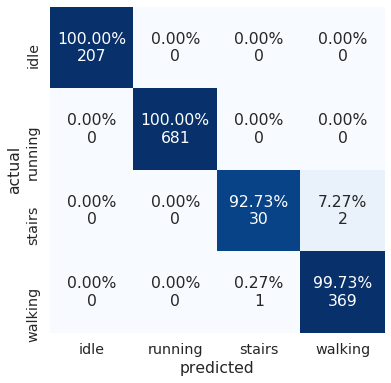

In [370]:
X = transform.fit_transform(feature_df[all_features])
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X[train_ix], X[valid_ix]
    y_train, y_valid = y[train_ix], y[valid_ix]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    cls = linear_model.LogisticRegression(max_iter=5_000, C=1.0)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['f1_min'])
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics)


# Hyperopt

In [316]:
from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin

In [380]:
X = transform.fit_transform(feature_df[all_features])
y = feature_df['label'].values

def logreg_optim_objective(params):
    cv_metrics = []

    for train_ix, valid_ix in kfold.split(X, y):
        X_train, X_valid = X[train_ix], X[valid_ix]
        y_train, y_valid = y[train_ix], y[valid_ix]
        
        if params['use_scaling']:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_valid = scaler.transform(X_valid)

#         cls = linear_model.LogisticRegression(C=params['C'], max_iter=5_000)
#         cls.fit(X_train, y_train)
#         y_pred = cls.predict(X_valid)

#         fold_metrics = evaluate_performance(y_valid, y_pred)
#         cv_metrics.append(fold_metrics)
        cls = linear_model.LogisticRegression(max_iter=5_000, C=params['C'])
        cls.fit(X_train, y_train)
        y_pred = cls.predict(X_valid)

        fold_metrics = evaluate_performance(y_valid, y_pred)
        cv_metrics.append(fold_metrics)
    loss = 1 - pd.DataFrame(cv_metrics)['f1_min'].mean()
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [382]:
logreg_optim_objective({'use_scaling': True, 'C': 1})

{'loss': 0.05326140899773435,
 'params': {'use_scaling': True, 'C': 1},
 'status': 'ok'}

In [383]:
space = {
    'C' : hp.uniform('C', 0.05, 3),
    'use_scaling' : hp.choice('use_scaling', [True, False])
}

MAX_EVALS = 60

In [384]:
bayes_trials = Trials()

# Optimize
best = fmin(fn = logreg_optim_objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

  0%|          | 0/60 [00:00<?, ?trial/s, best loss=?]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

  2%|▏         | 1/60 [00:50<49:13, 50.06s/trial, best loss: 0.036737988379779374]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

  3%|▎         | 2/60 [01:42<49:00, 50.69s/trial, best loss: 0.036737988379779374]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



  5%|▌         | 3/60 [01:46<34:51, 36.69s/trial, best loss: 0.036737988379779374]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

  7%|▋         | 4/60 [02:40<39:16, 42.07s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

  8%|▊         | 5/60 [03:32<41:14, 44.99s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 10%|█         | 6/60 [04:27<43:05, 47.88s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 12%|█▏        | 7/60 [05:20<43:46, 49.56s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 13%|█▎        | 8/60 [05:24<31:02, 35.83s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 15%|█▌        | 9/60 [06:17<34:48, 40.94s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 17%|█▋        | 10/60 [07:10<37:16, 44.72s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 18%|█▊        | 11/60 [08:05<38:53, 47.63s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 20%|██        | 12/60 [09:04<40:45, 50.95s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 22%|██▏       | 13/60 [09:11<29:39, 37.86s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 23%|██▎       | 14/60 [10:09<33:40, 43.92s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 27%|██▋       | 16/60 [10:26<19:02, 25.97s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 28%|██▊       | 17/60 [11:35<27:48, 38.81s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 30%|███       | 18/60 [12:40<32:38, 46.62s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 32%|███▏      | 19/60 [13:42<35:07, 51.40s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 33%|███▎      | 20/60 [13:51<25:51, 38.78s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 35%|███▌      | 21/60 [14:53<29:40, 45.65s/trial, best loss: 0.030399053682635846]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 37%|███▋      | 22/60 [15:55<32:03, 50.61s/trial, best loss: 0.02750861079219291] 

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 38%|███▊      | 23/60 [16:56<33:02, 53.59s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 40%|████      | 24/60 [17:57<33:33, 55.94s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 42%|████▏     | 25/60 [19:02<34:07, 58.50s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 43%|████▎     | 26/60 [20:02<33:25, 58.99s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 45%|████▌     | 27/60 [21:00<32:13, 58.59s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 47%|████▋     | 28/60 [22:00<31:36, 59.27s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 48%|████▊     | 29/60 [23:00<30:39, 59.32s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 50%|█████     | 30/60 [23:06<21:38, 43.29s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 52%|█████▏    | 31/60 [24:04<23:05, 47.79s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 53%|█████▎    | 32/60 [25:07<24:27, 52.39s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 55%|█████▌    | 33/60 [26:09<24:51, 55.24s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 57%|█████▋    | 34/60 [26:17<17:49, 41.15s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 58%|█████▊    | 35/60 [27:19<19:42, 47.28s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 60%|██████    | 36/60 [28:18<20:23, 50.97s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 62%|██████▏   | 37/60 [29:20<20:45, 54.14s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 63%|██████▎   | 38/60 [29:29<14:52, 40.58s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 65%|██████▌   | 39/60 [30:30<16:23, 46.83s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 67%|██████▋   | 40/60 [31:31<17:01, 51.10s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 68%|██████▊   | 41/60 [32:35<17:21, 54.80s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 70%|███████   | 42/60 [33:35<16:56, 56.48s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 72%|███████▏  | 43/60 [33:40<11:37, 41.03s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 73%|███████▎  | 44/60 [34:43<12:41, 47.61s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 75%|███████▌  | 45/60 [35:44<12:52, 51.53s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 77%|███████▋  | 46/60 [35:54<09:06, 39.06s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 78%|███████▊  | 47/60 [36:55<09:55, 45.83s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 80%|████████  | 48/60 [37:57<10:05, 50.44s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 82%|████████▏ | 49/60 [38:58<09:50, 53.65s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 83%|████████▎ | 50/60 [39:07<06:41, 40.20s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 85%|████████▌ | 51/60 [40:08<06:59, 46.56s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 87%|████████▋ | 52/60 [41:09<06:46, 50.76s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 88%|████████▊ | 53/60 [42:12<06:22, 54.60s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 90%|█████████ | 54/60 [42:18<04:00, 40.09s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 92%|█████████▏| 55/60 [43:18<03:49, 45.83s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 93%|█████████▎| 56/60 [44:10<03:11, 47.89s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 95%|█████████▌| 57/60 [45:02<02:27, 49.04s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 97%|█████████▋| 58/60 [45:10<01:13, 36.78s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

 98%|█████████▊| 59/60 [46:02<00:41, 41.17s/trial, best loss: 0.02750861079219291]

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

100%|██████████| 60/60 [46:53<00:00, 46.90s/trial, best loss: 0.02750861079219291]


/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



In [386]:
best

{'C': 1.32160829920236, 'use_scaling': 1}

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  31   2]
 [  0   0   2 368]]


/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  33   0]
 [  0   0   1 369]]


/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  32   1]
 [  0   0   1 369]]


/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  30   3]
 [  0   0   1 369]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  32   1]
 [  0   0   0 370]]
        accuracy    f1_macro     f1_min
mean    0.998143    0.990004   0.963256
std   0.00117333  0.00638286  0.0234869


/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


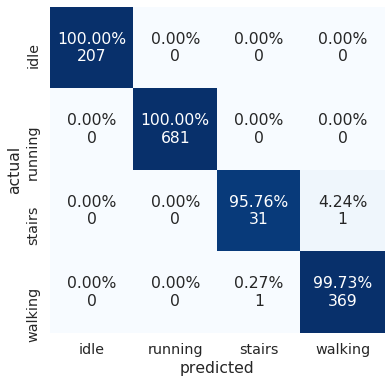

In [388]:
X = transform.fit_transform(feature_df[all_features])
y = feature_df['label']
cv_metrics = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X[train_ix], X[valid_ix]
    y_train, y_valid = y[train_ix], y[valid_ix]
    
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_valid = scaler.transform(X_valid)
    cls = linear_model.LogisticRegression(max_iter=5_000, C=1.3)
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    
    fold_metrics = evaluate_performance(y_valid, y_pred)
    cv_metrics.append(fold_metrics)
    print(fold_metrics['CM_not_normalized'])
print_cv_metrics(cv_metrics)

In [360]:
best

{'C': 2.9684849965093996, 'solver': 0, 'use_scaling': 1}

In [354]:
%%time
logreg_optim_objective({'use_scaling': False, 'solver': 'lbfgs', 'C': 1})

/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

CPU times: user 41.9 s, sys: 731 ms, total: 42.7 s
Wall time: 7.12 s


/home/kilianovski/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'loss': 0.17985455079793444,
 'params': {'use_scaling': False, 'solver': 'lbfgs', 'C': 1},
 'status': 'ok'}

In [151]:
cls.coef_.shape

(4, 209)

In [154]:
len([(feature_name, score) for feature_name, score in list(zip(transform.get_feature_names(all_features), cls.coef_.min(axis=0))) if np.abs(score) < 1e-5])

172

In [155]:
209 - 172

37

In [112]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
cls = linear_model.LogisticRegression(solver='liblinear', penalty='l1')
cls.fit(X_train, y_train)


In [113]:
confusion_matrix(y_pred, y_valid)

array([[208,   0,   0,   0],
       [  0, 681,   0,   0],
       [  0,   0,  29,   4],
       [  0,   0,   4, 366]])

In [115]:
X_train.shape

(5170, 19)

In [119]:
cls.coef_.shape

(4, 19)

array([-5.44600762, -9.75175713, -5.3422712 , -0.34121835, -1.60088442,
       -1.76696115, -1.01441776, -0.95303517, -0.49234904, -0.83559681,
       -0.8449462 , -1.73906215, -2.96130259, -1.11790575, -1.7654351 ,
       -6.18761231, -1.31172606, -1.24290891, -0.21264137])

In [121]:
list(zip(all_features, ))

[('mean_x', -5.4460076176709205),
 ('mean_y', -9.751757125669487),
 ('mean_z', -5.342271200759968),
 ('mean_m', -0.3412183516395128),
 ('minmax_x', -1.600884418050687),
 ('minmax_y', -1.7669611510845873),
 ('minmax_z', -1.0144177592798787),
 ('minmax_m', -0.9530351712833459),
 ('min_x', -0.4923490412471908),
 ('min_y', -0.8355968089499377),
 ('min_z', -0.8449462005092604),
 ('min_m', -1.7390621510442512),
 ('rms_x', -2.9613025865129377),
 ('rms_y', -1.117905752189049),
 ('rms_z', -1.765435100250287),
 ('rms_m', -6.187612308092692),
 ('corr_xy', -1.311726057945506),
 ('corr_yz', -1.2429089140381602),
 ('corr_xz', -0.21264137345022988)]

In [93]:
from sklearn.ensemble import RandomForestClassifier

In [94]:
X = feature_df[all_features]
y = feature_df['label']
f_scores = []

for train_ix, valid_ix in kfold.split(X, y):
    X_train, X_valid = X.loc[train_ix], X.loc[valid_ix]
    y_train, y_valid = y.loc[train_ix], y.loc[valid_ix]
    
    cls = RandomForestClassifier()
    cls.fit(X_train, y_train)
    y_pred = cls.predict(X_valid)
    f_scores.append(accuracy_score(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))
    
print(f'Accuracy mean: {round(np.mean(f_scores), 2)}, std: {round(np.std(f_scores), 2)}')

[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  31   2]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 682   0   0]
 [  0   0  33   0]
 [  0   0   0 370]]
[[207   0   0   0]
 [  0 682   0   0]
 [  0   0  30   3]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  33   0]
 [  0   0   0 370]]
[[208   0   0   0]
 [  0 681   0   0]
 [  0   0  30   3]
 [  0   0   0 370]]
Accuracy mean: 1.0, std: 0.0


In [29]:
cls = linear_model.LogisticRegression(max_iter=2_000)
cls.fit(X_train, y_train)
y_pred = cls.predict(X_valid)

In [30]:
cls.coef_

array([[-1.11693219,  1.26996541,  2.64989393],
       [ 0.8761829 ,  0.48161475, -0.95354791],
       [ 0.52349184, -0.55169286, -1.38645113],
       [-0.28274254, -1.19988731, -0.30989489]])

In [27]:
mean_features

['mean_x', 'mean_y', 'mean_z', 'mean_m']

Feature engineering